<a href="https://colab.research.google.com/github/Abhishekai1/KC-GNN/blob/main/KC-GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Device: cpu
[Loader] Using synthetic fallback.
KG: D=220, P=380, X=140 | D2P_I=1289 D2P_A=1085 P2X=2635


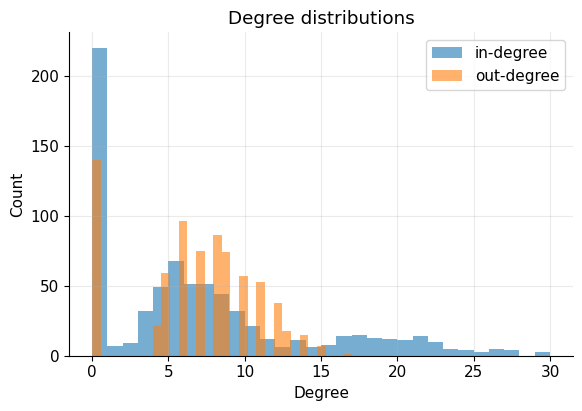

[baseline] epoch 01 | loss=10.5087 (task 10.509, rules 0.000, irm 0.000) | val AUC=0.523 AP=0.511
[baseline] epoch 05 | loss=24.5220 (task 24.522, rules 0.000, irm 0.000) | val AUC=0.536 AP=0.536
[baseline] epoch 10 | loss=2.6265 (task 2.626, rules 0.000, irm 0.000) | val AUC=0.631 AP=0.632
[baseline] epoch 15 | loss=0.6309 (task 0.631, rules 0.000, irm 0.000) | val AUC=0.641 AP=0.586
[baseline] epoch 20 | loss=0.5196 (task 0.520, rules 0.000, irm 0.000) | val AUC=0.664 AP=0.608
[baseline] epoch 25 | loss=0.4179 (task 0.418, rules 0.000, irm 0.000) | val AUC=0.714 AP=0.638
[baseline] TEST: AUC=0.701 AP=0.640 ACC@0.5=0.645 | time=2.1s
[rules] epoch 01 | loss=92.4120 (task 41.649, rules 84.605, irm 0.000) | val AUC=0.500 AP=0.500
[rules] epoch 05 | loss=18.8528 (task 7.341, rules 19.187, irm 0.000) | val AUC=0.497 AP=0.498
[rules] epoch 10 | loss=8.7954 (task 3.540, rules 8.759, irm 0.000) | val AUC=0.469 AP=0.481
[rules] epoch 15 | loss=1.5669 (task 0.663, rules 1.507, irm 0.000) | val 

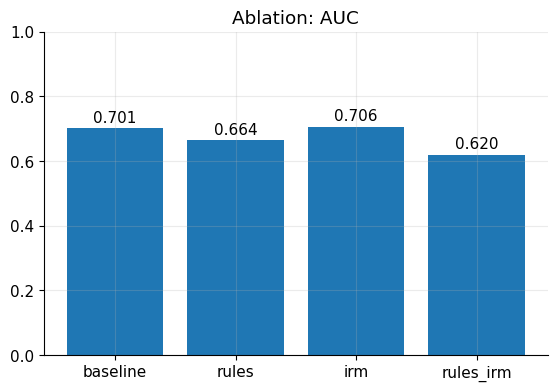

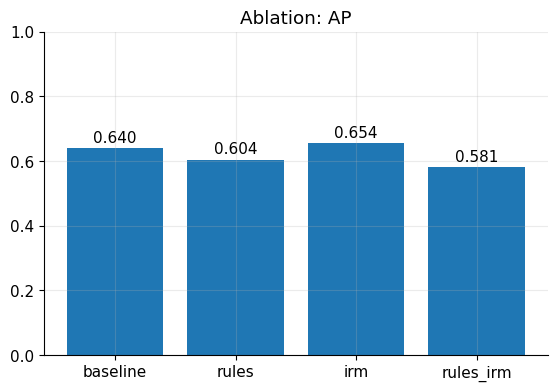

Best config: irm


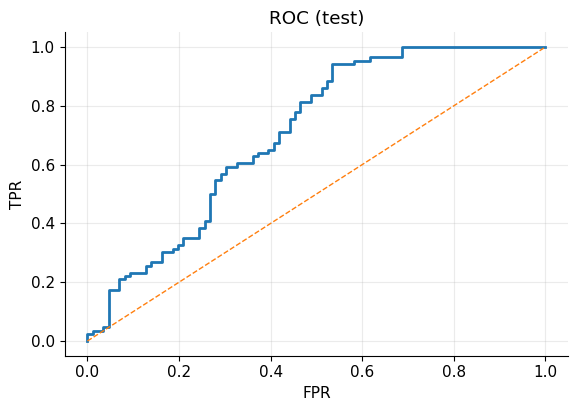

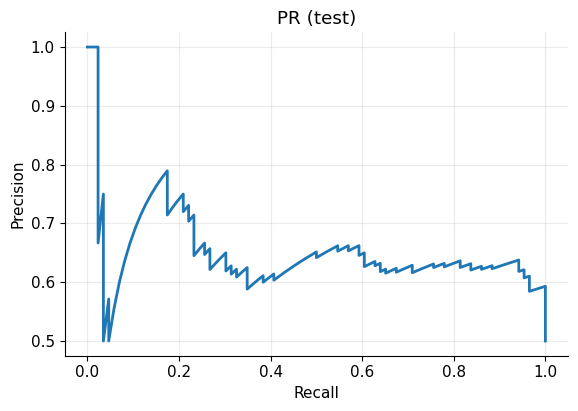

Brier score: 0.2501920157915771


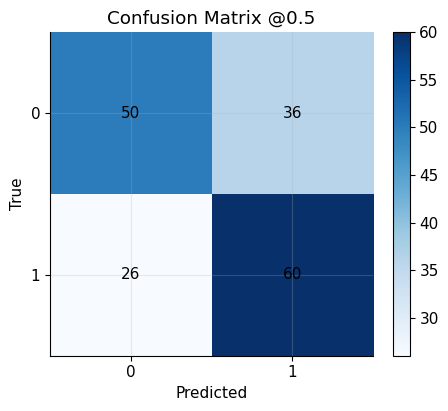

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


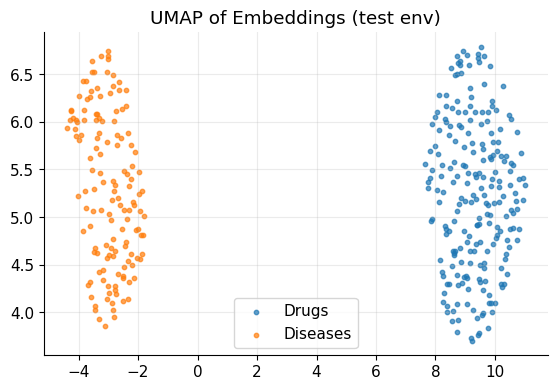

Drug 65 top diseases: [(53, 0.9330866932868958), (99, 0.8598597645759583), (85, 0.8444529175758362), (81, 0.8346099853515625), (18, 0.8322348594665527), (137, 0.8280889391899109), (67, 0.8262315392494202), (37, 0.791753888130188)]


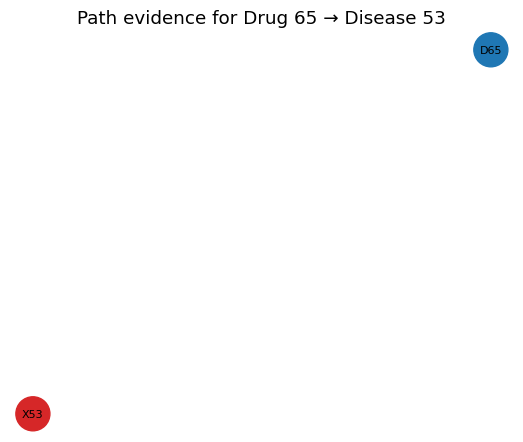

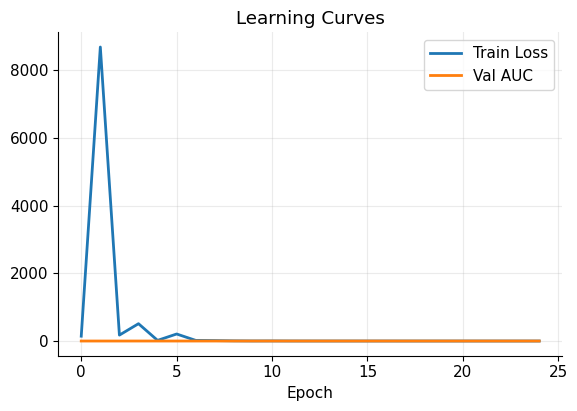

Artifacts saved in ./artifacts


In [6]:
import os, sys, math, time, random, json, csv, pathlib, textwrap
from typing import Dict, List, Tuple, Any, Optional, Set
from dataclasses import dataclass

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import umap
from sklearn.metrics import (
    roc_auc_score, average_precision_score, roc_curve, precision_recall_curve,
    brier_score_loss, confusion_matrix
)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

plt.rcParams.update({
    "figure.figsize": (6.5, 4.2),
    "font.size": 11,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "savefig.dpi": 200,
})

# --------------------------
# Repro
# --------------------------
def set_seed(seed: int = 7):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(7)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

@dataclass
class HeteroKG:
    G: nx.DiGraph
    nD: int
    nP: int
    nX: int
    d_dim: int
    p_dim: int
    x_dim: int
    # typed features
    D: np.ndarray
    P: np.ndarray
    X: np.ndarray
    # edges by relation
    D2P_I: List[Tuple[int,int]]
    D2P_A: List[Tuple[int,int]]
    P2X:   List[Tuple[int,int]]
    # pos/neg pairs for D->X treats
    train_pos: List[Tuple[int,int]]
    train_neg: List[Tuple[int,int]]
    val_pos: List[Tuple[int,int]]
    val_neg: List[Tuple[int,int]]
    test_pos: List[Tuple[int,int]]
    test_neg: List[Tuple[int,int]]
    # environment shifts for IRM-like perturbations (proteins)
    envs: List[Dict[str, Any]]
    env_assign: Dict[str, List[int]]
    # optional SCM params (needed for synthetic fallback interventions)
    Wp: Optional[np.ndarray] = None
    Wd: Optional[np.ndarray] = None
    Wx: Optional[np.ndarray] = None
    W_xp: Optional[np.ndarray] = None
    bias_x: Optional[np.ndarray] = None

def try_load_hetionet(data_dir="/content/data/hetionet", dim=64) -> Optional[HeteroKG]:
    try:
        if not os.path.isdir(data_dir):
            return None
        nodes_path = os.path.join(data_dir, "nodes.csv")
        edges_path = os.path.join(data_dir, "edges.csv")
        if not (os.path.isfile(nodes_path) and os.path.isfile(edges_path)):
            return None

        nodes = pd.read_csv(nodes_path)
        edges = pd.read_csv(edges_path)

        # Standardize expected node types: Compound (D), Gene/Protein (P), Disease (X)
        # We accept several common labels:
        drug_labels     = {"Compound", "Drug", "Chemical"}
        gene_labels     = {"Gene", "Protein", "Gene/Protein"}
        disease_labels  = {"Disease", "Phenotype", "DiseaseOrPhenotypicFeature"}

        id2type = dict(zip(nodes["id"], nodes["type"]))
        # Indexing within type
        d_ids, p_ids, x_ids = [], [], []
        for nid, t in id2type.items():
            if t in drug_labels: d_ids.append(nid)
            elif t in gene_labels: p_ids.append(nid)
            elif t in disease_labels: x_ids.append(nid)

        d_ids = sorted(d_ids); p_ids = sorted(p_ids); x_ids = sorted(x_ids)
        d_map = {nid:i for i,nid in enumerate(d_ids)}
        p_map = {nid:i for i,nid in enumerate(p_ids)}
        x_map = {nid:i for i,nid in enumerate(x_ids)}

        # Features: look for precomputed per-type npy files. If missing, random init.
        def maybe_load_feat(fname, n, dim):
            fpath = os.path.join(data_dir, fname)
            if os.path.isfile(fpath):
                arr = np.load(fpath)
                assert arr.shape == (n, arr.shape[1])
                return arr.astype(np.float32)
            else:
                return np.random.randn(n, dim).astype(np.float32)

        D = maybe_load_feat(f"features_compound_dim{dim}.npy", n=len(d_ids), dim=dim)
        P = maybe_load_feat(f"features_gene_dim{dim}.npy",     n=len(p_ids), dim=dim)
        X = maybe_load_feat(f"features_disease_dim{dim}.npy",  n=len(x_ids), dim=dim)

        # Build directed graph + relations
        G = nx.DiGraph()
        for i in range(len(d_ids)): G.add_node(("D", i), type="D", x=D[i])
        for i in range(len(p_ids)): G.add_node(("P", i), type="P", x=P[i])
        for i in range(len(x_ids)): G.add_node(("X", i), type="X", x=X[i])

        # Relation mapping heuristics
        D2P_I, D2P_A, P2X = [], [], []
        treats_pos = set()  # collect positives for D->X "treats"

        for _, row in edges.iterrows():
            s, t, r = row["src"], row["dst"], str(row["rel"]).lower()
            stype = id2type.get(s, "")
            ttype = id2type.get(t, "")
            # Map to internal indices if typed
            if stype in drug_labels and ttype in gene_labels:
                if "inhibit" in r or "antagon" in r or "downreg" in r:
                    if s in d_map and t in p_map:
                        D2P_I.append((d_map[s], p_map[t]))
                        G.add_edge(("D", d_map[s]), ("P", p_map[t]), rel="I")
                elif "activate" in r or "agon" in r or "upreg" in r or "bind" in r or "target" in r:
                    if s in d_map and t in p_map:
                        D2P_A.append((d_map[s], p_map[t]))
                        G.add_edge(("D", d_map[s]), ("P", p_map[t]), rel="A")
            elif stype in gene_labels and ttype in disease_labels:
                if "assoc" in r or "implicate" in r or "involve" in r or "cause" in r:
                    if s in p_map and t in x_map:
                        P2X.append((p_map[s], x_map[t]))
                        G.add_edge(("P", p_map[s]), ("X", x_map[t]), rel="Assoc")
            elif stype in drug_labels and ttype in disease_labels:
                # ground-truth treats (optional)
                if "treat" in r or "indication" in r or "approved" in r:
                    if s in d_map and t in x_map:
                        treats_pos.add((d_map[s], x_map[t]))

        def split(arr):
            arr = list(arr)
            random.shuffle(arr)
            n = len(arr)
            n_train = int(0.7*n); n_val = int(0.15*n)
            return arr[:n_train], arr[n_train:n_train+n_val], arr[n_train+n_val:]

        if len(treats_pos) >= 200:
            pos_pairs = list(treats_pos)
        else:
            # Weak positives: (d,x) that have at least one P with D->P and P->X
            pos_pairs = set()
            P_from_D = {}
            for d,p in D2P_I + D2P_A:
                P_from_D.setdefault(d, set()).add(p)
            X_from_P = {}
            for p,x in P2X:
                X_from_P.setdefault(p, set()).add(x)
            for d, plist in P_from_D.items():
                xs = set()
                for p in plist:
                    xs |= X_from_P.get(p, set())
                # keep a few to balance class
                for x in random.sample(sorted(list(xs)), k=min(5, len(xs))):
                    pos_pairs.add((d,x))
            pos_pairs = list(pos_pairs)

        # Negatives: sample random D-X that are not positive
        pos_set = set(pos_pairs)
        neg_pairs = set()
        nd, nx_ = len(d_ids), len(x_ids)
        while len(neg_pairs) < len(pos_pairs):
            d = random.randrange(nd); x = random.randrange(nx_)
            if (d,x) not in pos_set:
                neg_pairs.add((d,x))
        neg_pairs = list(neg_pairs)

        train_pos, val_pos, test_pos = split(pos_pairs)
        train_neg, val_neg, test_neg = split(neg_pairs)

        # Build envs (IRM perturbations on P features)
        def mk_envs(n_envs=3, p_dim=P.shape[1]):
            envs = []
            for e in range(n_envs):
                direction = np.random.randn(p_dim).astype(np.float32)
                direction /= (np.linalg.norm(direction) + 1e-6)
                magnitude = 0.5*(e+1)
                envs.append({"shift": direction*magnitude})
            return envs

        envs = mk_envs(3, P.shape[1])
        env_assign = {"train":[0,1], "val":[2], "test":[2]}

        print(f"[Hetionet loader] D={len(d_ids)} P={len(p_ids)} X={len(x_ids)} | D2P_I={len(D2P_I)} D2P_A={len(D2P_A)} P2X={len(P2X)} | pos={len(pos_pairs)}")
        return HeteroKG(
            G=G, nD=len(d_ids), nP=len(p_ids), nX=len(x_ids),
            d_dim=D.shape[1], p_dim=P.shape[1], x_dim=X.shape[1],
            D=D, P=P, X=X,
            D2P_I=D2P_I, D2P_A=D2P_A, P2X=P2X,
            train_pos=train_pos, train_neg=train_neg, val_pos=val_pos, val_neg=val_neg, test_pos=test_pos, test_neg=test_neg,
            envs=envs, env_assign=env_assign
        )
    except Exception as e:
        print("[Hetionet loader] Failed:", repr(e))
        return None

# ============================================================
# Synthetic fallback (from the earlier script), trimmed & improved
# ============================================================
class SyntheticDrugKG:
    def __init__(self, n_drugs=220, n_proteins=380, n_diseases=140, dim=64, n_envs=3, seed=7):
        set_seed(seed)
        self.nD, self.nP, self.nX = n_drugs, n_proteins, n_diseases
        self.d_dim = self.p_dim = self.x_dim = dim
        self.G = nx.DiGraph()
        # add nodes
        for i in range(self.nD): self.G.add_node(("D", i), x=np.random.randn(dim).astype(np.float32), type="D")
        for i in range(self.nP): self.G.add_node(("P", i), x=np.random.randn(dim).astype(np.float32), type="P")
        for i in range(self.nX): self.G.add_node(("X", i), x=np.random.randn(dim).astype(np.float32), type="X")
        # edges
        self.D2P_I, self.D2P_A, self.P2X = [], [], []
        for d in range(self.nD):
            deg = np.random.poisson(4)+1
            proteins = np.random.choice(self.nP, size=min(deg+6, self.nP), replace=False)
            for p in proteins:
                if np.random.rand()<0.55:
                    self.D2P_I.append((d,p)); self.G.add_edge(("D",d),("P",p),rel="I")
                else:
                    self.D2P_A.append((d,p)); self.G.add_edge(("D",d),("P",p),rel="A")
        for p in range(self.nP):
            deg = np.random.poisson(3)+1
            diseases = np.random.choice(self.nX, size=min(deg+3, self.nX), replace=False)
            for x in diseases:
                self.P2X.append((p,x)); self.G.add_edge(("P",p),("X",x),rel="Assoc")
        # SCM params
        self.Wp = np.random.randn(dim).astype(np.float32)
        self.Wd = np.random.randn(dim).astype(np.float32)
        self.Wx = np.random.randn(dim).astype(np.float32)
        self.W_xp = np.random.randn(self.nX, self.nP).astype(np.float32) * 0.08
        self.bias_x = np.random.randn(self.nX).astype(np.float32) * 0.1
        # envs
        self.envs = []
        for e in range(n_envs):
            direction = np.random.randn(dim).astype(np.float32); direction/= (np.linalg.norm(direction)+1e-6)
            self.envs.append({"shift": direction * (0.45*(e+1))})
        self.env_assign = {"train":[0,1], "val":[2], "test":[2]}
        # labels
        self.pos_pairs, self.neg_pairs = self._make_labels()
        self.train_pos, self.val_pos, self.test_pos = self._split(self.pos_pairs)
        self.train_neg, self.val_neg, self.test_neg = self._split(self.neg_pairs)

    def _protein_activity(self, p_feat, shift):
        z = float(np.dot(p_feat + shift, self.Wp)); return 1/(1+np.exp(-z))
    def _drug_effect(self, d_feat, rel):
        base = 1/(1+np.exp(-float(np.dot(d_feat, self.Wd)))); return base if rel=="A" else -base

    def _make_labels(self):
        A0 = np.zeros(self.nP, dtype=np.float32)
        shift = self.envs[0]["shift"]
        for p in range(self.nP): A0[p] = self._protein_activity(self.G.nodes[("P",p)]["x"], shift)
        def risk(Ap):
            return 1/(1+np.exp(-(np.einsum("xp,p->x", self.W_xp, Ap)+ self.bias_x)))
        R0 = risk(A0)
        dp_effects = {}
        for d in range(self.nD):
            dfeat = self.G.nodes[("D",d)]["x"]
            for _, (t,p), ed in self.G.out_edges(("D",d), data=True):
                if t!="P": continue
                dp_effects[(d,p)] = self._drug_effect(dfeat, ed["rel"])
        pos = set(); neg=set()
        for d in range(self.nD):
            Ap = A0.copy()
            for p in range(self.nP):
                if (d,p) in dp_effects: Ap[p]+= dp_effects[(d,p)]
            delta = R0 - risk(Ap)
            for x in np.argsort(-delta)[:5]:
                if delta[x]>0.06: pos.add((d,x))
        while len(neg)<len(pos):
            d=np.random.randint(self.nD); x=np.random.randint(self.nX)
            if (d,x) not in pos: neg.add((d,x))
        return list(pos), list(neg)

    def _split(self, arr):
        arr=list(arr); random.shuffle(arr)
        n=len(arr); n_train=int(0.7*n); n_val=int(0.15*n)
        return arr[:n_train], arr[n_train:n_train+n_val], arr[n_train+n_val:]

def load_kg(real_first=True, data_dir="/content/data/hetionet", dim=64) -> HeteroKG:
    kg_real = try_load_hetionet(data_dir=data_dir, dim=dim) if real_first else None
    if kg_real is not None:
        return kg_real
    print("[Loader] Using synthetic fallback.")
    syn = SyntheticDrugKG(dim=dim)
    # pack into HeteroKG-like struct
    D = np.stack([syn.G.nodes[("D",i)]["x"] for i in range(syn.nD)])
    P = np.stack([syn.G.nodes[("P",i)]["x"] for i in range(syn.nP)])
    X = np.stack([syn.G.nodes[("X",i)]["x"] for i in range(syn.nX)])
    return HeteroKG(
        G=syn.G, nD=syn.nD, nP=syn.nP, nX=syn.nX,
        d_dim=syn.d_dim, p_dim=syn.p_dim, x_dim=syn.x_dim,
        D=D, P=P, X=X,
        D2P_I=syn.D2P_I, D2P_A=syn.D2P_A, P2X=syn.P2X,
        train_pos=syn.train_pos, train_neg=syn.train_neg, val_pos=syn.val_pos, val_neg=syn.val_neg, test_pos=syn.test_pos, test_neg=syn.test_neg,
        envs=syn.envs, env_assign=syn.env_assign,
        Wp=syn.Wp, Wd=syn.Wd, Wx=syn.Wx, W_xp=syn.W_xp, bias_x=syn.bias_x
    )

# ============================================================
# Model (with residual projection fix)
# ============================================================
class RelGraphSAGE(nn.Module):
    def __init__(self, d_in, p_in, x_in, hidden=192, out=160, dropout=0.15):
        super().__init__()
        self.d1 = nn.Linear(d_in, hidden)
        self.p1 = nn.Linear(p_in, hidden)
        self.x1 = nn.Linear(x_in, hidden)
        # relation projections
        self.rel_D2P_I = nn.Linear(hidden, hidden)
        self.rel_D2P_A = nn.Linear(hidden, hidden)
        self.rel_P2X   = nn.Linear(hidden, hidden)
        # aggregators
        self.agg_P = nn.Linear(hidden*2, hidden)
        self.agg_X = nn.Linear(hidden*2, hidden)
        # second layer + residual adapters
        self.d2 = nn.Linear(hidden, out)
        self.p2 = nn.Linear(hidden, out)
        self.x2 = nn.Linear(hidden, out)
        self.res_p = nn.Linear(hidden, out)
        self.res_x = nn.Linear(hidden, out)
        self.dropout = nn.Dropout(dropout)
        self.reset_parameters()

    def reset_parameters(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def message_pass(self, D_h, P_h, X_h, D2P_I, D2P_A, P2X):
        P_msg = torch.zeros_like(P_h)
        if D2P_I.shape[1] > 0:
            d_src, p_dst = D2P_I[0], D2P_I[1]
            P_msg.index_add_(0, p_dst, self.rel_D2P_I(D_h[d_src]))
        if D2P_A.shape[1] > 0:
            d_src, p_dst = D2P_A[0], D2P_A[1]
            P_msg.index_add_(0, p_dst, self.rel_D2P_A(D_h[d_src]))
        P_new = F.relu(self.agg_P(torch.cat([P_h, P_msg], dim=-1)))
        P_new = self.dropout(P_new)

        X_msg = torch.zeros_like(X_h)
        if P2X.shape[1] > 0:
            p_src, x_dst = P2X[0], P2X[1]
            X_msg.index_add_(0, x_dst, self.rel_P2X(P_new[p_src]))
        X_new = F.relu(self.agg_X(torch.cat([X_h, X_msg], dim=-1)))
        X_new = self.dropout(X_new)
        return P_new, X_new

    def forward(self, D_in, P_in, X_in, D2P_I, D2P_A, P2X):
        D_h = F.relu(self.d1(D_in))
        P_h = F.relu(self.p1(P_in))
        X_h = F.relu(self.x1(X_in))
        P_h1, X_h1 = self.message_pass(D_h, P_h, X_h, D2P_I, D2P_A, P2X)
        D_h2 = F.relu(self.d2(D_h))
        P_h2 = F.relu(self.p2(P_h1)) + self.res_p(P_h1)
        X_h2 = F.relu(self.x2(X_h1)) + self.res_x(X_h1)
        return D_h2, P_h2, X_h2

class DXBilinearDecoder(nn.Module):
    def __init__(self, dim, bias=True):
        super().__init__()
        self.B = nn.Parameter(torch.empty(dim, dim))
        nn.init.xavier_uniform_(self.B)
        self.b = nn.Parameter(torch.zeros(1)) if bias else None
    def forward(self, D_repr, X_repr, d_idx, x_idx):
        d = D_repr[d_idx]; x = X_repr[x_idx]
        s = torch.sum(d @ self.B * x, dim=-1)
        return s + (self.b if self.b is not None else 0.0)

# ============================================================
# Rules & IRM Components
# ============================================================
class RuleEngine:
    def __init__(self, D2P_I, D2P_A, P2X, nD, nP, nX, device):
        self.device = device
        self.nD, self.nP, self.nX = nD, nP, nX
        self.P_to_X_list = [[] for _ in range(nP)]
        if len(P2X)>0:
            for p,x in P2X: self.P_to_X_list[p].append(x)
        self.D_to_P_I = [[] for _ in range(nD)]
        if len(D2P_I)>0:
            for d,p in D2P_I: self.D_to_P_I[d].append(p)
        self.D_to_P_A = [[] for _ in range(nD)]
        if len(D2P_A)>0:
            for d,p in D2P_A: self.D_to_P_A[d].append(p)

    def rule_pairs(self, max_per_drug=60):
        pos, neg = set(), set()
        for d in range(self.nD):
            Pa = self.D_to_P_A[d]
            if Pa:
                subset = Pa if len(Pa)<=max_per_drug else random.sample(Pa, max_per_drug)
                for p in subset:
                    for x in self.P_to_X_list[p]:
                        neg.add((d,x))
            Pi = self.D_to_P_I[d]
            if Pi:
                subset = Pi if len(Pi)<=max_per_drug else random.sample(Pi, max_per_drug)
                for p in subset:
                    for x in self.P_to_X_list[p]:
                        pos.add((d,x))
        return list(pos), list(neg)

def invariance_penalty(logits, labels):
    scale = torch.tensor(1.0, device=logits.device, requires_grad=True)
    loss = F.binary_cross_entropy_with_logits(logits * scale, labels)
    grad = torch.autograd.grad(loss, [scale], create_graph=True)[0]
    return torch.sum(grad**2)

def pair_tensor(pairs, device):
    if len(pairs)==0:
        return torch.empty(0,dtype=torch.long,device=device), torch.empty(0,dtype=torch.long,device=device)
    a = torch.tensor([i for i,_ in pairs], dtype=torch.long, device=device)
    b = torch.tensor([j for _,j in pairs], dtype=torch.long, device=device)
    return a,b

# ============================================================
# Training / Eval Utilities
# ============================================================
@dataclass
class TrainConfig:
    hidden:int=192; out:int=160; dropout:float=0.15
    lr:float=2e-3; weight_decay:float=1e-4
    epochs:int=25; batch_size:int=4096
    lambda_rule:float=0.6; lambda_irm:float=0.25
    use_rules:bool=True; use_irm:bool=True
    dim:int=64

def to_tensors(kg: HeteroKG):
    D_feat = torch.tensor(kg.D, dtype=torch.float32, device=device)
    P_feat = torch.tensor(kg.P, dtype=torch.float32, device=device)
    X_feat = torch.tensor(kg.X, dtype=torch.float32, device=device)
    D2P_I_t = torch.tensor(kg.D2P_I, dtype=torch.long, device=device).t() if len(kg.D2P_I)>0 else torch.empty(2,0,dtype=torch.long,device=device)
    D2P_A_t = torch.tensor(kg.D2P_A, dtype=torch.long, device=device).t() if len(kg.D2P_A)>0 else torch.empty(2,0,dtype=torch.long,device=device)
    P2X_t   = torch.tensor(kg.P2X,   dtype=torch.long, device=device).t() if len(kg.P2X)>0   else torch.empty(2,0,dtype=torch.long,device=device)
    return D_feat, P_feat, X_feat, D2P_I_t, D2P_A_t, P2X_t

def env_P_features(kg: HeteroKG, P_feat, env_id):
    shift = kg.envs[env_id]["shift"]
    return P_feat + torch.tensor(shift, device=device).unsqueeze(0)

def sample_batch(pos_pairs, neg_pairs, batch_size=4096):
    half = batch_size//2
    pos = random.sample(pos_pairs, min(half, len(pos_pairs)))
    neg = random.sample(neg_pairs, min(half, len(neg_pairs)))
    pairs = pos + neg
    labels = torch.tensor([1]*len(pos) + [0]*len(neg), dtype=torch.float32, device=device)
    idx = np.arange(len(pairs)); np.random.shuffle(idx)
    pairs = [pairs[i] for i in idx]
    labels = labels[idx.tolist()]
    d_idx, x_idx = pair_tensor(pairs, device)
    return d_idx, x_idx, labels

def evaluate(model, decoder, kg, D_feat, P_feat, X_feat, D2P_I_t, D2P_A_t, P2X_t, pairs_pos, pairs_neg):
    model.eval()
    with torch.no_grad():
        D_repr, P_repr, X_repr = model(D_feat, P_feat, X_feat, D2P_I_t, D2P_A_t, P2X_t)
    def scores(pairs):
        if len(pairs)==0: return np.array([]), np.array([])
        d,x = pair_tensor(pairs, device)
        with torch.no_grad():
            p = torch.sigmoid(decoder(D_repr, X_repr, d, x)).cpu().numpy()
        y = np.ones(len(pairs), dtype=np.float32)
        return p,y
    p_pos, y_pos = scores(pairs_pos)
    p_neg, y_neg = scores(pairs_neg); y_neg[:] = 0.0
    p = np.concatenate([p_pos, p_neg]); y = np.concatenate([y_pos, y_neg])
    auc = roc_auc_score(y, p) if len(np.unique(y))>1 else float("nan")
    ap  = average_precision_score(y, p) if len(np.unique(y))>1 else float("nan")
    t=0.5; pred=(p>=t).astype(np.float32); acc=(pred==y).mean()
    return {"AUC":auc, "AP":ap, "ACC@0.5":acc, "p":p, "y":y}

def rule_losses(decoder, D_repr, X_repr, rule_pos_pairs, rule_neg_pairs, sample_k=2500):
    rp = rule_pos_pairs if len(rule_pos_pairs)<=sample_k else random.sample(rule_pos_pairs, sample_k)
    rn = rule_neg_pairs if len(rule_neg_pairs)<=sample_k else random.sample(rule_neg_pairs, sample_k)
    loss = 0.0
    if len(rp)>0:
        d,x = pair_tensor(rp, device); s = decoder(D_repr, X_repr, d, x)
        loss += F.binary_cross_entropy_with_logits(s, torch.ones_like(s))
    if len(rn)>0:
        d,x = pair_tensor(rn, device); s = decoder(D_repr, X_repr, d, x)
        loss += F.binary_cross_entropy_with_logits(s, torch.zeros_like(s))
    if isinstance(loss, float): return torch.tensor(0.0, device=device)
    return loss

def train_once(kg: HeteroKG, cfg: TrainConfig, tag="exp"):
    # tensors
    D_feat, P_feat, X_feat, D2P_I_t, D2P_A_t, P2X_t = to_tensors(kg)
    model = RelGraphSAGE(kg.d_dim, kg.p_dim, kg.x_dim, hidden=cfg.hidden, out=cfg.out, dropout=cfg.dropout).to(device)
    decoder = DXBilinearDecoder(dim=cfg.out, bias=True).to(device)
    opt = Adam(list(model.parameters())+list(decoder.parameters()), lr=cfg.lr, weight_decay=cfg.weight_decay)

    rule_engine = RuleEngine(kg.D2P_I, kg.D2P_A, kg.P2X, kg.nD, kg.nP, kg.nX, device)
    rule_pos_pairs, rule_neg_pairs = rule_engine.rule_pairs(max_per_drug=80)

    history = {"train_loss":[], "val_auc":[]}
    t0 = time.perf_counter()
    for epoch in range(1, cfg.epochs+1):
        model.train()
        d_idx, x_idx, y = sample_batch(kg.train_pos, kg.train_neg, batch_size=cfg.batch_size)
        loss_task = 0.0; loss_irm = 0.0

        # multi-env training
        for env_id in kg.env_assign["train"]:
            P_env = env_P_features(kg, P_feat, env_id)
            D_repr, P_repr, X_repr = model(D_feat, P_env, X_feat, D2P_I_t, D2P_A_t, P2X_t)
            logits = decoder(D_repr, X_repr, d_idx, x_idx)
            loss_task = loss_task + F.binary_cross_entropy_with_logits(logits, y)
            if cfg.use_irm:
                loss_irm = loss_irm + invariance_penalty(logits, y)

        loss_task = loss_task / len(kg.env_assign["train"])
        if cfg.use_irm:
            loss_irm = loss_irm / len(kg.env_assign["train"])
        else:
            loss_irm = torch.tensor(0.0, device=device)

        # rules on base env
        if cfg.use_rules:
            with torch.no_grad():
                P_env0 = env_P_features(kg, P_feat, kg.env_assign["train"][0])
            D0,P0,X0 = model(D_feat, P_env0, X_feat, D2P_I_t, D2P_A_t, P2X_t)
            loss_rules = rule_losses(decoder, D0, X0, rule_pos_pairs, rule_neg_pairs, sample_k=2000)
        else:
            loss_rules = torch.tensor(0.0, device=device)

        loss = loss_task + cfg.lambda_rule*loss_rules + cfg.lambda_irm*loss_irm

        opt.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(list(model.parameters())+list(decoder.parameters()), 2.0)
        opt.step()

        val = evaluate(model, decoder, kg, D_feat, env_P_features(kg, P_feat, kg.env_assign["val"][0]), X_feat, D2P_I_t, D2P_A_t, P2X_t, kg.val_pos, kg.val_neg)
        history["train_loss"].append(float(loss.detach().cpu()))
        history["val_auc"].append(float(val["AUC"]))

        if epoch%5==0 or epoch==1:
            print(f"[{tag}] epoch {epoch:02d} | loss={float(loss):.4f} (task {float(loss_task):.3f}, rules {float(loss_rules):.3f}, irm {float(loss_irm):.3f}) | val AUC={val['AUC']:.3f} AP={val['AP']:.3f}")

    dur = time.perf_counter()-t0
    test = evaluate(model, decoder, kg, D_feat, env_P_features(kg, P_feat, kg.env_assign["test"][0]), X_feat, D2P_I_t, D2P_A_t, P2X_t, kg.test_pos, kg.test_neg)
    print(f"[{tag}] TEST: AUC={test['AUC']:.3f} AP={test['AP']:.3f} ACC@0.5={test['ACC@0.5']:.3f} | time={dur:.1f}s")

    # Save logs
    os.makedirs("./logs", exist_ok=True)
    pd.DataFrame({"epoch":np.arange(1,cfg.epochs+1), "train_loss":history["train_loss"], "val_auc":history["val_auc"]}).to_csv(f"./logs/{tag}_history.csv", index=False)

    return model, decoder, history, test, dur

# ============================================================
# Run: load data, ablations, plots
# ============================================================
kg = load_kg(real_first=True, data_dir="/content/data/hetionet", dim=64)
print(f"KG: D={kg.nD}, P={kg.nP}, X={kg.nX} | D2P_I={len(kg.D2P_I)} D2P_A={len(kg.D2P_A)} P2X={len(kg.P2X)}")
D_feat, P_feat, X_feat, D2P_I_t, D2P_A_t, P2X_t = to_tensors(kg)

# --- Visualize basic KG stats ---
def plot_degree_distributions(kg):
    G = kg.G
    indeg = [G.in_degree(n) for n in G.nodes()]
    outdeg= [G.out_degree(n) for n in G.nodes()]
    fig, ax = plt.subplots()
    ax.hist(indeg, bins=30, alpha=.6, label="in-degree")
    ax.hist(outdeg,bins=30, alpha=.6, label="out-degree")
    ax.set_title("Degree distributions")
    ax.set_xlabel("Degree"); ax.set_ylabel("Count"); ax.legend()
    plt.show()

plot_degree_distributions(kg)

# --- Ablations ---
base_cfg = TrainConfig(epochs=25, batch_size=4096, use_rules=False, use_irm=False)
rules_cfg= TrainConfig(epochs=25, batch_size=4096, use_rules=True,  use_irm=False)
irm_cfg  = TrainConfig(epochs=25, batch_size=4096, use_rules=False, use_irm=True)
full_cfg = TrainConfig(epochs=25, batch_size=4096, use_rules=True,  use_irm=True)

results = []
for tag, cfg in [("baseline", base_cfg), ("rules", rules_cfg), ("irm", irm_cfg), ("rules_irm", full_cfg)]:
    m, dec, hist, test, secs = train_once(kg, cfg, tag=tag)
    results.append({"tag":tag, "AUC":test["AUC"], "AP":test["AP"], "ACC":test["ACC@0.5"], "secs":secs, "model":m, "decoder":dec, "history":hist, "test":test})

# --- Bar chart: ablation metrics ---
def bar_ablation(results, metric="AUC"):
    order = ["baseline","rules","irm","rules_irm"]
    vals = [next(r[metric] for r in results if r["tag"]==t) for t in order]
    fig, ax = plt.subplots()
    ax.bar(order, vals)
    ax.set_title(f"Ablation: {metric}")
    ax.set_ylim(0.0, 1.0)
    for i,v in enumerate(vals):
        ax.text(i, v+0.01, f"{v:.3f}", ha="center", va="bottom")
    plt.show()

bar_ablation(results, "AUC")
bar_ablation(results, "AP")

# Pick best model by AUC
best = max(results, key=lambda r: r["AUC"])
model, decoder = best["model"], best["decoder"]
print("Best config:", best["tag"])

# --- Paper-ready curves (ROC, PR, Calibration) ---
y = best["test"]["y"]; p = best["test"]["p"]
fpr, tpr, _ = roc_curve(y, p)
prec, rec, _ = precision_recall_curve(y, p)

fig, ax = plt.subplots()
ax.plot(fpr, tpr, lw=2)
ax.plot([0,1],[0,1], ls="--", lw=1)
ax.set_title("ROC (test)"); ax.set_xlabel("FPR"); ax.set_ylabel("TPR")
plt.show()

fig, ax = plt.subplots()
ax.plot(rec, prec, lw=2)
ax.set_title("PR (test)"); ax.set_xlabel("Recall"); ax.set_ylabel("Precision")
plt.show()

# calibration + confusion at 0.5
bs = brier_score_loss(y, p)
print("Brier score:", bs)
t=0.5; pred=(p>=t).astype(np.int32)
cm = confusion_matrix(y.astype(np.int32), pred)
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap="Blues")
for (i,j),v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha="center", va="center")
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
ax.set_title("Confusion Matrix @0.5")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.show()

# --- Embedding UMAP for interpretability (Drugs / Diseases) ---
@torch.no_grad()
def get_embeddings(model, D_feat, P_feat, X_feat, env_id=0):
    P_env = env_P_features(kg, P_feat, env_id)
    D_repr, P_repr, X_repr = model(D_feat, P_env, X_feat, D2P_I_t, D2P_A_t, P2X_t)
    return D_repr.cpu().numpy(), P_repr.cpu().numpy(), X_repr.cpu().numpy()

D_emb, P_emb, X_emb = get_embeddings(model, D_feat, P_feat, X_feat, env_id=kg.env_assign["test"][0])
reducer = umap.UMAP(n_neighbors=25, min_dist=0.1, random_state=7)
XY = reducer.fit_transform(np.vstack([D_emb[:300], X_emb[:300]]))
labels = (["Drug"]*min(300,len(D_emb))) + (["Disease"]*min(300,len(X_emb)))

fig, ax = plt.subplots()
ax.scatter(XY[:min(300,len(D_emb)),0], XY[:min(300,len(D_emb)),1], s=10, alpha=.7, label="Drugs")
ax.scatter(XY[min(300,len(D_emb)):,0], XY[min(300,len(D_emb)):,1], s=10, alpha=.7, label="Diseases")
ax.legend(); ax.set_title("UMAP of Embeddings (test env)")
plt.show()

# --- Local subgraph viz around a top recommendation ---
def topk_for_drug(model, decoder, d_id:int, k:int=10):
    d = torch.full((kg.nX,), d_id, dtype=torch.long, device=device)
    x = torch.arange(kg.nX, dtype=torch.long, device=device)
    with torch.no_grad():
        D_repr, P_repr, X_repr = model(D_feat, env_P_features(kg, P_feat, kg.env_assign["test"][0]), X_feat, D2P_I_t, D2P_A_t, P2X_t)
        s = torch.sigmoid(decoder(D_repr, X_repr, d, x)).cpu().numpy()
    idx = np.argsort(-s)[:k]
    return idx, s[idx]

def visualize_local_subgraph(kg: HeteroKG, d_id:int, x_id:int, max_nodes=60):
    G = kg.G
    # collect P that connect d->p and p->x
    P_neighbors = set([v for (_, (t, v)) in G.out_edges(("D", d_id)) if t=="P"])
    P_reach = [p for p in P_neighbors if G.has_edge(("P", p), ("X", x_id))]
    H = nx.Graph()
    H.add_node(f"D{d_id}", color="tab:blue")
    H.add_node(f"X{x_id}", color="tab:red")
    for p in P_reach[:max_nodes]:
        H.add_node(f"P{p}", color="tab:green")
        rel = G[("D", d_id)][("P", p)]["rel"]
        H.add_edge(f"D{d_id}", f"P{p}", label=rel)
        H.add_edge(f"P{p}", f"X{x_id}", label="Assoc")
    pos = nx.spring_layout(H, seed=3, k=0.5)
    colors = [H.nodes[n].get("color","gray") for n in H.nodes()]
    labels = nx.get_edge_attributes(H, 'label')
    fig, ax = plt.subplots(figsize=(6.5, 5.2))
    nx.draw(H, pos, with_labels=True, node_color=colors, node_size=600, font_size=8, ax=ax)
    nx.draw_networkx_edge_labels(H, pos, edge_labels=labels, font_size=8, ax=ax)
    ax.set_title(f"Path evidence for Drug {d_id} → Disease {x_id}")
    plt.show()

d_probe = random.randrange(kg.nD)
top_idx, top_scores = topk_for_drug(model, decoder, d_probe, k=8)
print(f"Drug {d_probe} top diseases:", list(zip(top_idx.tolist(), [float(v) for v in top_scores])))
visualize_local_subgraph(kg, d_probe, int(top_idx[0]))

# --- Learning curves for best run ---
hist = best["history"]
fig, ax = plt.subplots()
ax.plot(hist["train_loss"], lw=2, label="Train Loss")
ax.plot(hist["val_auc"], lw=2, label="Val AUC")
ax.set_xlabel("Epoch"); ax.legend(); ax.set_title("Learning Curves")
plt.show()

# --- Save final artifacts ---
os.makedirs("./artifacts", exist_ok=True)
torch.save(model.state_dict(), f"./artifacts/{best['tag']}_model.pt")
torch.save(decoder.state_dict(), f"./artifacts/{best['tag']}_decoder.pt")
with open("./artifacts/summary.json","w") as f:
    json.dump({k: (float(v) if isinstance(v, (np.floating, float)) else v) for k,v in best.items() if k in ["tag","AUC","AP","ACC","secs"]}, f, indent=2)
print("Artifacts saved in ./artifacts")
